In [1]:
import gym
import copy
import time
import random
import logging
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from functools import partial
from collections import OrderedDict, namedtuple
from typing import Deque, Dict, List, Tuple

from IPython import display
from matplotlib import animation
%matplotlib inline

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
gym.__version__, torch.__version__

('0.18.3', '1.7.1+cu101')

In [2]:
env_name = "CartPole-v0"
env = gym.make(env_name)

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True

SEED = 777
seed_everything(SEED)

In [3]:
state_dim = env.observation_space.shape[0]
action_dim = 1
max_action = 1
state_dim, action_dim, max_action

(4, 1, 1)

In [4]:
def descrete_map(a): return int(a > 0)

In [5]:
def _plot(frame_idx, **options):
    """Plot the training progresses.
    optional parameter:
    scores
    actor_losses
    critic_losses
    entropys
    approx_kls
    clipfracs
    alpha_losses
    """
    n = len(options)
    assert n != 0, '.................'
    scores = options.pop('scores', None)
    actor_losses = options.pop('actor_losses', None)
    critic_losses = options.pop('critic_losses', None)
    entropys = options.pop('entropys', None)  
    approx_kls = options.pop('approx_kls', None) 
    clipfracs = options.pop('clipfracs', None)
    alpha_losses = options.pop('alpha_losses', None)
    
    def subplot(loc: int, title: str, values: List[float]):
        plt.subplot(loc)
        plt.title(title)
        plt.plot(values)

    subplot_params = [
        (f"frame {frame_idx}. score: {np.mean(scores[-10:]):.2f}", scores),
        ("actor_loss", actor_losses),
        ("critic_loss", critic_losses),
        ("entropy", entropys),
        ("approx_kl", approx_kls),
        ("clipfracs", clipfracs),
        ("alpha_losses", alpha_losses)
    ]

    display.clear_output(True)
    plt.figure(figsize=(35, 7))
    
    i = 0
    for title, values in subplot_params:
        if values == None:
            continue
        i += 1
        loc = int(f'1{n}{i}')
        subplot(loc, title, values)
        
    plt.show()
        
plt.rcParams.update({'font.size': 20})

In [6]:
class Buffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, act_dim: int, max_size=int):
        """Initializate."""
        self.obs_buf = np.zeros((max_size, obs_dim), dtype=np.float32) 
        self.next_obs_buf = np.zeros((max_size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros((max_size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros((max_size, 1), dtype=np.float32)
        self.done_buf = np.zeros((max_size, 1), dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, max_size    
        
    def store(self, 
              obs: np.ndarray, 
              act, 
              next_obs,
              rew,
              done,
             ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
        
    def sample(self, bs=32):
        idxs = np.random.randint(0, self.size, size=bs) 
        batch = dict(obs=self.obs_buf[idxs], 
                     next_obs=self.next_obs_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     mask=1.-self.done_buf[idxs],
                   )
        
        return {k: torch.FloatTensor(v).to(device) for k,v in batch.items()}
 

    def __len__(self) -> int:
        return self.size
    
# agent
def initialize_uniformly(layer: nn.Linear, init_w: float = 3e-3):
    """Initialize the weights and bias in [-init_w, init_w]."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)


class Actor(nn.Module):
    def __init__(
            self,
            state_dim: int,
            action_dim: int,
            max_act: float,
            init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Actor, self).__init__()
        self.hidden1 = nn.Linear(state_dim, 256)
        self.hidden2 = nn.Linear(256, 256)
        
        self.alpha = nn.Linear(256, action_dim)
        initialize_uniformly(self.alpha)
        
        self.beta = nn.Linear(256, action_dim)
        initialize_uniformly(self.beta)
        
        self.max_action = max_action
        self.max_log_std = 2
        self.min_log_std = -20
        
    def forward(self, state, is_stochastic=False, with_log_prob=False):
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        alpha = F.softplus(self.alpha(x)) + 1
        beta = F.softplus(self.beta(x)) + 1
        dist = torch.distributions.Beta(alpha, beta) 
        
        if is_stochastic:
            #log_std = self.min_log_std + 0.5 * (self.max_log_std - self.min_log_std) * (log_std + 1)
                    
            action = dist.rsample()
        else:
            action = dist.mean
            
        if with_log_prob:
            log_prob = dist.log_prob(action)
            log_prob = log_prob.sum(axis=1, keepdims=True)
        else:
            log_prob = None
            
        return (action - 0.5) * 2. * self.max_action, log_prob


class Critic(nn.Module):
    def __init__(
        self, 
        state_dim: int, 
        action_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()
        
        self.l11 = nn.Linear(state_dim + action_dim, 256)
        self.l12 = nn.Linear(256, 256)
        self.l13 = nn.Linear(256, 1)
        
        self.l21 = nn.Linear(state_dim + action_dim, 256)
        self.l22 = nn.Linear(256, 256)
        self.l23 = nn.Linear(256, 1)
               
        initialize_uniformly(self.l13)
        initialize_uniformly(self.l23)

    def forward(self, x):
        raise NotImplementedError
    
    def q1(self, state, action):
        x = torch.cat((state, action), dim=1)
        
        q1 = F.relu(self.l11(x))
        q1 = F.relu(self.l12(q1))
        q1 = self.l13(q1)
        return q1
    
    def q2(self, state, action):
        x = torch.cat((state, action), dim=1)
        
        q2 = F.relu(self.l21(x))
        q2 = F.relu(self.l22(q2))
        q2 = self.l23(q2)
        return q2


class SAC(object):
    def __init__(self,
                 state_dim,
                 action_dim,
                 max_action,
                 p_lr=1e-3,
                 q_lr=1e-3,
                 discount=0.99,
                 polyak=0.995,
                 alpha=0.2,
                 auto_tuning_entropy=True,
                 target_entropy=None
                 ):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=p_lr)
        
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=q_lr)
        self.target_critic = copy.deepcopy(self.critic)
        self.freeze(self.target_critic)
        
        self.max_action = max_action
        self.gamma = discount
        self.polyak = polyak
        self.policy_noise = 0.3 * self.max_action # 0.3
        self.noise_clip = 0.5 * self.max_action
        
        self.alpha = alpha
        self.alpha_lr = 1e-3
        self.auto_tuning_entropy = auto_tuning_entropy
        if self.auto_tuning_entropy:        
            if target_entropy != None:
                self.target_entropy = target_entropy
            else:
                self.target_entropy = -np.prod(env.action_space.shape).item()
            self.log_alpha = (torch.randn(1) * 0.1).to(device).requires_grad_(True)
            self.alpha_opt = torch.optim.Adam([self.log_alpha], lr=self.alpha_lr)
            
        
    def choose_action(self, s, is_stochastic=False):
        s = torch.FloatTensor([s]).to(device)
        return self.actor(s, is_stochastic)[0].cpu().data.numpy().flatten()

    def update(self, memory, bs=256):
        data = memory.sample(bs)
        s = data['obs']
        a = data['act']
        next_s, r, mask = data['next_obs'], data['rew'] , data['mask']
        
        # train alpha
        if self.auto_tuning_entropy:
            self.alpha_opt.zero_grad()
            alpha_loss = self.compute_alpha_loss(data)
            alpha_loss.backward()
            self.alpha_opt.step()
            self.alpha = self.log_alpha.exp()
        else:
            alpha_loss = np.array([0.])
        
        # train critic
        self.critic_opt.zero_grad()
        critic_loss = self.compute_critic_loss(data)
        critic_loss.backward()
        self.critic_opt.step()
        
        # train actor
        self.actor_opt.zero_grad()
        actor_loss = self.compute_policy_loss(data)
        actor_loss.backward()
        self.actor_opt.step()

        # update target network
        self.soft_update_targs()
            
        return actor_loss.item(), critic_loss.item(), alpha_loss.item()

    def compute_policy_loss(self, data):
        self.freeze(self.critic)
        s = data['obs']
        
        act, log_prob = self.actor(s, is_stochastic=True, with_log_prob=True)
        q1 = self.critic.q1(s, act)
        q2 = self.critic.q2(s, act)
        q = torch.min(q1, q2)
        
        actor_loss = (self.alpha * log_prob - q).mean()
        self.unfreeze(self.critic)
        return actor_loss

    def compute_critic_loss(self, data):
        s = data['obs']
        a = data['act']
        next_s, r, mask = data['next_obs'], data['rew'] , data['mask']
        with torch.no_grad():
            # Target actions come from *current* policy
            next_act, next_log_prob = self.actor(next_s, is_stochastic=True, with_log_prob=True)
            # TD3 Trick Three: Target Policy Smoothing.
            noise = (torch.randn_like(next_act) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            next_act = (next_act + noise).clamp(-self.max_action, self.max_action)
            
            # Target Q-values
            targ_q1 = self.target_critic.q1(next_s, next_act)
            targ_q2 = self.target_critic.q2(next_s, next_act)
            targ_q = torch.min(targ_q1, targ_q2)
            ret = r + self.gamma * mask * (targ_q - self.alpha * next_log_prob)
            
        q1 = self.critic.q1(s, a)
        q2 = self.critic.q2(s, a)
        return F.mse_loss(q1, ret) + F.mse_loss(q2, ret)
    
    def compute_alpha_loss(self, data):
        s = data['obs']
        _, log_prob = self.actor(s, is_stochastic=True, with_log_prob=True)
        alpha_loss = - (self.log_alpha * (log_prob + self.target_entropy).detach()).mean()       
        return alpha_loss

    def soft_update_targs(self):
        """Soft-update: target = polyak*target + (1-polyak)*local."""
        with torch.no_grad():
            for p, p_targ in zip(self.critic.parameters(), self.target_critic.parameters()):
                p_targ.data.copy_(self.polyak * p_targ.data +
                                  (1.0 - self.polyak) * p.data)

    def unfreeze(self, model):
        for p in model.parameters():
            p.requires_grad = True

    def freeze(self, model):
        for p in model.parameters():
            p.requires_grad = False

In [18]:
episodes = 100000
targ_score = 190
buffer_size = int(1e6)
max_step = 20000
initial_random_steps = 200
update_after = 200
update_every = 1
multi_update = 1
reward_scales = 1.0
save_model = False
bs = 64
max_episode_steps = 200

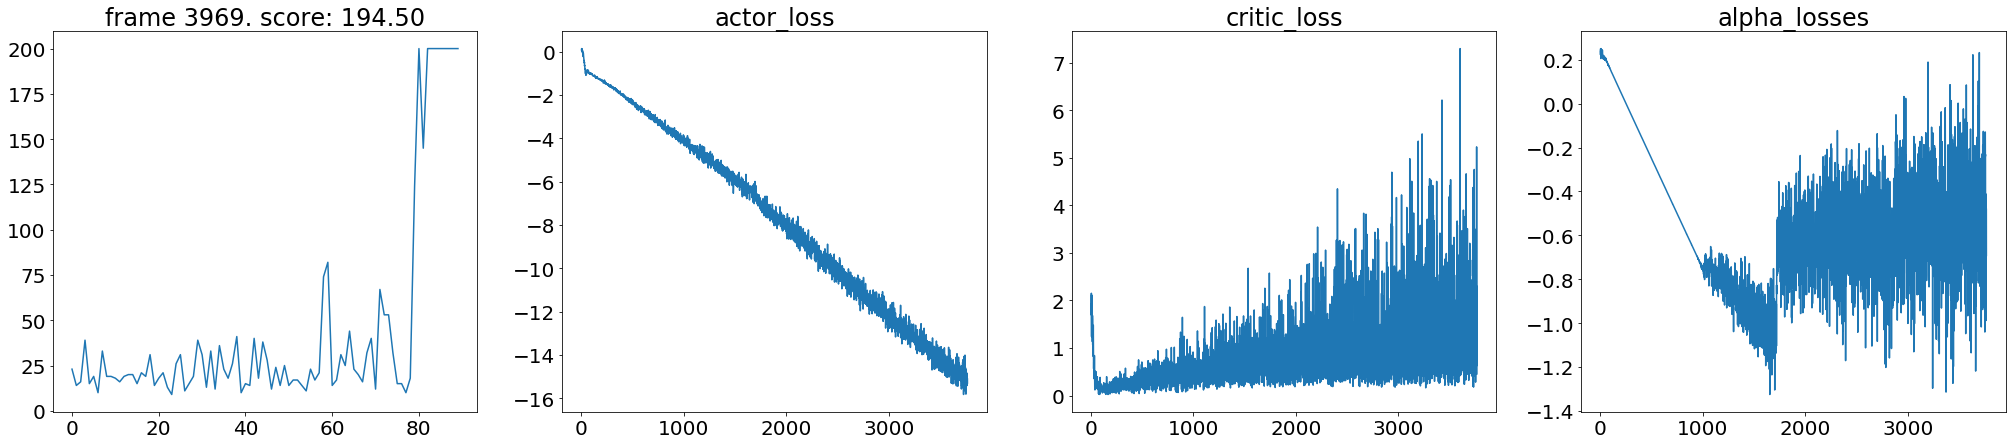

Finish!
episode: 90, score: mean: 194.50 max: 200.00


In [19]:
%time
# main loop
memory = Buffer(state_dim, action_dim, buffer_size)
policy = SAC(
    state_dim,
    action_dim,
    max_action,
    p_lr=3e-4,
    q_lr=3e-4,
    discount=0.99,
    polyak=0.995,
)

score_list = []
actor_losses, critic_losses, alpha_losses = [], [], []
total_step = 0
best_score = 0

for episode in range(1, episodes + 1):
    ep_step = 0
    score = 0
    s = env.reset()

    while True:
        total_step += 1
        ep_step += 1

        # act
        if total_step < initial_random_steps:
            # a = env.action_space.sample()
            a = random.uniform(-max_action, max_action)
            
        else:
            a = policy.choose_action(s, is_stochastic=True)
            
        next_s, r, done, _ = env.step(descrete_map(a))
        done_bool = float(done) if ep_step < max_episode_steps else 0
        # tuning reward
        r_tuned = (r if not done else 0.) * reward_scales
        memory.store(s, a, next_s, r_tuned, done_bool)

        score += r
        s = next_s

        # update
        if (total_step >= update_after and total_step % update_every == 0):
            for _ in range(multi_update):
                actor_loss, critic_loss, alpha_loss = policy.update(memory, bs)
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)
                alpha_losses.append(alpha_loss)

        if done:
            score_list.append(score)
            print(
                f'episode: {episode}, ep_step: {ep_step}, score: {score: .2f}, max: {max(score_list):.2f}'
            )
            if np.mean(score_list[-10:]) > best_score:
                best_score = np.mean(score_list[-10:])
                if save_model:
                    torch.save(policy.actor.state_dict(), f'SAC_beta2_{env_name}_checkpoint.pth')
                                      
            if episode % 5 == 0 and total_step >= update_after:  # plot
                _plot(total_step,
                      scores=score_list,
                      actor_losses=actor_losses,
                      critic_losses=critic_losses,
                      alpha_losses=alpha_losses)
            break

        if total_step >= max_step:
            break

    # stop, and save model
    if (np.mean(score_list[-10:]) > targ_score or total_step >= max_step
            or episode == episodes):
        _plot(total_step,
              scores=score_list,
              actor_losses=actor_losses,
              critic_losses=critic_losses,
              alpha_losses=alpha_losses)
        print('Finish!')
        print(
            f'episode: {episode}, score: mean: {np.mean(score_list[-10:]):.2f} max: {max(score_list):.2f}'
        )
        break
env.close()

In [20]:
frames = []
env = gym.make(env_name)


for i in range(10):
    s = env.reset()
    #env.render()
    score = 0
    
    while True:
        #env.render()
        a = policy.choose_action(s, is_stochastic=True)

        s, r, done, _ = env.step(descrete_map(a))
        score += r

        if done:  # game over
            print(f'score: {score:.2f}') 
            break
env.close()

score: 200.00
score: 200.00
score: 200.00
score: 200.00
score: 200.00
score: 200.00
score: 200.00
score: 192.00
score: 200.00
score: 200.00
